In [1]:
import time
notebook_start_time = time.time()

# 0. Setup

In [2]:
from importlib.metadata import version

pkgs = [
    "numpy",       # PyTorch & TensorFlow dependency
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 2.0.2
matplotlib version: 3.10.0
tiktoken version: 0.9.0
torch version: 2.6.0+cu124
tqdm version: 4.67.1
tensorflow version: 2.18.0


# 1. Dataset downloading and formatting

In [3]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    # The book originally contained this unnecessary "else" clause:
    #else:
    #    with open(file_path, "r", encoding="utf-8") as file:
    #        text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [4]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [5]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


- we use Alpaca-style prompt formatting, which was the original prompt template for instruction finetuning
- we format the input that we will pass as input to the LLM

In [6]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

A formatted response with input field looks like as shown below

In [7]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [8]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


# 2. Organizing data into training batches

- first, let's split the dataset:

In [9]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


- Let's implement `InstructionDataset` class that pre-tokenizes all inputs in the dataset, similar to the `SpamDataset` class in classification finetuning:

In [10]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
  def __init__(self, data, tokenizer):
    self.data = data

    # pre-tokenizer texts
    self.encoded_texts = []
    for entry in data:
      instruction_plus_input = format_input(entry)
      response_text = f"\n\n### Response:\n{entry['output']}"
      full_text = instruction_plus_input + response_text
      self.encoded_texts.append(tokenizer.encode(full_text))

  def __getitem__(self, index):
    return self.encoded_texts[index]

  def __len__(self):
    return len(self.data)

- now use the <|endoftext|> token as a padding token and pad all inputs in a batch to a similar length (not the entire dataset)
- to do that, we custom "collate" function that can pass to the data loader
- This custom collate function pads the training examples in each batch to have the same length (but different batches can have different lengths)

In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [12]:
def custom_collate_draft_1(batch,
                           pad_token_id=50256,
                           device="cpu"):
  # find the longest sequence in the batch and increase max_length
  # by +1 for the padding token, which indicates the end of sequence/answer
  batch_max_length = max(len(item) + 1 for item in batch)

  # pad and prepare inputs
  inputs_lst = []

  for item in batch:
    new_item = item.copy()
    # Add an <|endoftext|> token
    new_item += [pad_token_id]
    # Pad sequences to batch_max_length
    padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))
    # Via padded[:-1], we remove the extra padded token
    # that has been added via the +1 setting in batch_max_length
    # (the extra padding token will be relevant in later codes)
    inputs = torch.tensor(padded[:-1])
    inputs_lst.append(inputs)

  # convert list of inputs to tensor and transfer to target device
  inputs_tensor = torch.stack(inputs_lst).to(device)
  return inputs_tensor

In [13]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


- but that only for input, for target, everything must be shifted by +1:

In [14]:
def custom_collate_draft_2(batch,
                           pad_token_id=50256,
                           device="cpu"):
  # find the longest sequence in the batch and increase max_length
  # by +1 for the padding token, which indicates the end of sequence/answer
  batch_max_length = max(len(item) + 1 for item in batch)

  # pad and prepare inputs
  inputs_lst = []
  targets_lst = []

  for item in batch:
    new_item = item.copy()
    # Add an <|endoftext|> token
    new_item += [pad_token_id]
    # Pad sequences to batch_max_length
    padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))

    inputs = torch.tensor(padded[:-1]) # Truncate the last token for inputs
    targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

    inputs_lst.append(inputs)
    targets_lst.append(targets)

  # convert list of inputs to tensor and transfer to target device
  inputs_tensor = torch.stack(inputs_lst).to(device)
  targets_tensor = torch.stack(targets_lst).to(device)
  return inputs_tensor, targets_tensor

In [15]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


- now convert the unnecessary padding tokens in `targets` (not `inputs`)that don't signify the end of sequence into `ignore_index` so that they won't affect loss during training
- also introduce the `allowed_max_length` in case we want to limit the length of the samples; this will be useful if you plan to work with your own datasets that are longer than the 1024 token context size supported by the GPT-2 model:

In [16]:
def custom_collate_fn(batch,
                      pad_token_id=50256,
                      ignore_index=-100,
                      allowed_max_length=None,
                      device="cpu"):
  # find the longest sequence in the batch and increase max_length
  # by +1 for the padding token, which indicates the end of sequence/answer
  batch_max_length = max(len(item) + 1 for item in batch)

  # pad and prepare inputs
  inputs_lst = []
  targets_lst = []

  for item in batch:
    new_item = item.copy()
    # Add an <|endoftext|> token
    new_item += [pad_token_id]
    # Pad sequences to batch_max_length
    padded = (new_item + [pad_token_id] * (batch_max_length - len(new_item)))

    inputs = torch.tensor(padded[:-1]) # Truncate the last token for inputs
    targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

    # replace all but the first padding tokens in targets by `ignore_index`
    mask = targets == pad_token_id
    padding_tokens_indices = torch.nonzero(mask).squeeze() # indices of the padding tokens in `targets`
    if padding_tokens_indices.numel() > 1:
      targets[padding_tokens_indices[1:]] = ignore_index

    # optionally truncate to maximum sequence length
    if allowed_max_length is not None:
      inputs = inputs[:allowed_max_length]
      targets = targets[:allowed_max_length]

    inputs_lst.append(inputs)
    targets_lst.append(targets)

  # convert list of inputs to tensor and transfer to target device
  inputs_tensor = torch.stack(inputs_lst).to(device)
  targets_tensor = torch.stack(targets_lst).to(device)

  return inputs_tensor, targets_tensor

In [17]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


- the reason why introduce `ignore_index`:

In [18]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [19]:
# add more training example will influence the loss
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [20]:
# try to replace the class label of one of the examples with -100
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


- Using this -100 `ignore_index`, we can ignore the additional end-of-text (padding) tokens in the batches that we used to pad the training examples to equal length
- However, we don't want to ignore the first instance of the end-of-text (padding) token (50256) because it can help signal to the LLM when the response is complete

# 3. Creating DataLoaders

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

- Using the `partial` function from Python's `functools` standard library, we create a new function with the `device` argument of the original function pre-filled:

In [22]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

- Next, we instantiate the data loaders, and provide our own collate function for the batching process:

In [23]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [24]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [25]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0')


In [26]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')


# 4. Loading a pretrained LLM

In [27]:
CHOOSE_MODEL = "gpt2-medium (355M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [28]:
import urllib.request

url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split("/")[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7a50188f24d0>)

In [29]:
from gpt_download import download_and_load_gpt2
import torch
import torch.nn as nn
import numpy as np



class MultiHeadAttention(nn.Module):
    def __init__(self,
                 input_embedding_dim,
                 output_embedding_dim,
                 context_length,
                 dropout,
                 num_heads,
                 qkv_bias=False):
        super().__init__()
        assert (output_embedding_dim % num_heads == 0), \
            "output_embedding_dim must be divisible by num_heads"

        self.output_embedding_dim = output_embedding_dim
        self.num_heads = num_heads
        self.head_dim = output_embedding_dim // num_heads
        self.W_query = nn.Linear(input_embedding_dim, output_embedding_dim,
                                 bias=qkv_bias)
        self.W_key = nn.Linear(input_embedding_dim, output_embedding_dim,
                               bias=qkv_bias)
        self.W_value = nn.Linear(input_embedding_dim, output_embedding_dim,
                                 bias=qkv_bias)
        self.output_projection = nn.Linear(output_embedding_dim,
                                           output_embedding_dim)  # to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1))

    def forward(self, inputs):
        batch, num_tokens, input_embedding_dim = inputs.shape

        # qkv shapes : (batch, num_tokens, output_embedding_dim)
        keys = self.W_key(inputs)
        values = self.W_value(inputs)
        queries = self.W_query(inputs)

        # qkv shapes : (batch, num_tokens, num_heads, head_dim)
        keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)

        # qkv shapes : (batch, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)

        # compute attention scores for each head
        attention_scores = queries @ keys.transpose(3, 2)
        attention_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], - torch.inf)

        # compute attention weights + dropout
        masked_attention_weight = torch.softmax(
            attention_scores / (keys.shape[-1] ** 0.5),
            dim=-1)
        masked_attention_dropout_weight = self.dropout(masked_attention_weight)

        # compute context vectors
        # shape : (batch, num_tokens, num_heads, head_dim)
        context_vector = (masked_attention_dropout_weight @ values).transpose(1, 2)

        # combine heads, where self.d_out = self.num_heads * self.head_dim
        # shape : (batch, num_tokens, output_embedding_dim)
        context_vector = context_vector.contiguous().view(
            batch, num_tokens, self.output_embedding_dim)

        # linear projection (optional)
        context_vector = self.output_projection(context_vector)

        return context_vector








class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.epsilon = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1,
                    unbiased=False,  # Bessel's correction (n-1)
                    keepdim=True)
        norm_x = (x - mean) / torch.sqrt(var + self.epsilon)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"],  # 768
                      4 * config["emb_dim"]),  # 3072
            GELU(),  # 3072
            nn.Linear(4 * config["emb_dim"],  # 3072
                      config["emb_dim"])  # 768
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(input_embedding_dim=config["emb_dim"],
                                            output_embedding_dim=config["emb_dim"],
                                            context_length=config["context_length"],
                                            dropout=config["drop_rate"],
                                            num_heads=config["n_heads"],
                                            qkv_bias=config["qkv_bias"])
        self.feed_forward = FeedForward(config)
        self.layer_norm1 = LayerNorm(config["emb_dim"])
        self.layer_norm2 = LayerNorm(config["emb_dim"])
        self.drop_skip = nn.Dropout(config["drop_rate"])

    def forward(self, x):
        # skip connection for attention block
        shortcut = x
        x = self.layer_norm1(x)
        x = self.attention(x)  # shape: [batch_size, num_tokens, emb_size]
        x = self.drop_skip(x)
        x = shortcut + x  # skip connection

        # skip connection for feed forward block
        shortcut = x
        x = self.layer_norm2(x)
        x = self.feed_forward(x)
        x = self.drop_skip(x)
        x = shortcut + x  # skip connection

        return x


class GPT2Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_emb = nn.Embedding(config["vocab_size"],
                                      config["emb_dim"])
        self.position_emb = nn.Embedding(config["context_length"],
                                         config["emb_dim"])
        self.drop_emb = nn.Dropout(config["drop_rate"])

        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config["n_layers"])])

        self.final_norm = LayerNorm(config["emb_dim"])

        self.out_head = nn.Linear(config["emb_dim"],
                                  config["vocab_size"],
                                  bias=False)

    def forward(self, input_token):
        batch_size, sequence_length = input_token.shape
        token_embeds = self.token_emb(input_token)
        position_embeds = self.position_emb(
            torch.arange(sequence_length,
                         device=input_token.device))
        embeds = token_embeds + position_embeds
        x = self.drop_emb(embeds)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits





def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_gpt(gpt, params):
    gpt.position_emb.weight = assign(gpt.position_emb.weight, params['wpe'])
    gpt.token_emb.weight = assign(gpt.token_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.weight = assign(
            gpt.transformer_blocks[b].attention.W_query.weight, q_w.T)
        gpt.transformer_blocks[b].attention.W_key.weight = assign(
            gpt.transformer_blocks[b].attention.W_key.weight, k_w.T)
        gpt.transformer_blocks[b].attention.W_value.weight = assign(
            gpt.transformer_blocks[b].attention.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.bias = assign(
            gpt.transformer_blocks[b].attention.W_query.bias, q_b)
        gpt.transformer_blocks[b].attention.W_key.bias = assign(
            gpt.transformer_blocks[b].attention.W_key.bias, k_b)
        gpt.transformer_blocks[b].attention.W_value.bias = assign(
            gpt.transformer_blocks[b].attention.W_value.bias, v_b)

        gpt.transformer_blocks[b].attention.output_projection.weight = assign(
            gpt.transformer_blocks[b].attention.output_projection.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].attention.output_projection.bias = assign(
            gpt.transformer_blocks[b].attention.output_projection.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transformer_blocks[b].feed_forward.layers[0].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[0].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_blocks[b].feed_forward.layers[2].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[2].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transformer_blocks[b].layer_norm1.scale = assign(
            gpt.transformer_blocks[b].layer_norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_blocks[b].layer_norm1.shift = assign(
            gpt.transformer_blocks[b].layer_norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_blocks[b].layer_norm2.scale = assign(
            gpt.transformer_blocks[b].layer_norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_blocks[b].layer_norm2.shift = assign(
            gpt.transformer_blocks[b].layer_norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [30]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
model_size

'355M'

In [31]:
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")
print(settings)
print(params.keys())

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe
{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 1024, 'n_head': 16, 'n_layer': 24}
dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [32]:
model = GPT2Model(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

- Let's check whether the model generates coherent text:


In [33]:
import tiktoken

def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

  # turn the list of token IDs into tensor with batch dimension
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(encoded_tensor, tokenizer):
  # turn tensor without batch dimension to list
  token_ids = encoded_tensor.squeeze(0).tolist()
  text = tokenizer.decode(token_ids)
  return text


def generate_text(model,
                  input_batch,
                  max_new_tokens,
                  context_size,
                  temperature=0.0,
                  top_k=None,
                  eos_id=None):
  for _ in range(max_new_tokens):
    # crop current context if it exceeds the supported context_size
    crop_input_batch = input_batch[:, -context_size:]

    # predict next token
    with torch.no_grad():
      logits = model(crop_input_batch)

    # consider only logits of the last token
    logits = logits[:, -1, :] # (batch, n_tokens, vocab_size) -> (batch, vocab_size)

    # NEW: filter logits with top_k sampling
    if top_k is not None:
      # keep only top_k values
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1] # min value among the top_k values
      # all values other than top_k values will be set to -inf
      logits = torch.where(logits < min_val,
                           torch.tensor(-torch.inf).to(logits.device),
                           logits)

    # NEW: temperature scaling
    if temperature > 0.0:
      logits = logits / temperature

      probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.multinomial(probas, num_samples=1) # (batch, 1)

    else: # same as before
      #probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.argmax(logits, dim=-1, keepdim=True) # (batch, 1)

    if predicted_tokens == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

    # update input_batch (append predicted tokens to the sequences)
    input_batch = torch.cat([input_batch, predicted_tokens], dim=1) # [batch, num_tokens+1]

  return input_batch

In [34]:
text_1 = "In the midst of winter"

token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=50,
    context_size=BASE_CONFIG["context_length"],
    temperature = 2.0,
    top_k = 10
)

print(token_ids_to_text(token_ids, tokenizer))

In the midst of winter, we are not sure what the future looks like in these parts. But the people we have here are the best we're ever likely to be, the most talented we'll probably get, the hardest worker we're ever going to be. And we


- let's see how the model performs on one of the instruction tasks:

In [35]:
torch.manual_seed(211)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [36]:
token_ids = generate_text(
    model=model,
    input_batch=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=100,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [37]:
generated_text

"Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nConvert the active sentence to passive: 'The chef cooks the meal every day.'\n\n### Response:\n\nThe chef cooks the meal every day.\n\n### Instruction:\n\nConvert the active sentence to passive: 'The chef cooks the meal every day.'\n\n### Response:\n\nThe chef cooks the meal every day.\n\n### Instruction:\n\nConvert the active sentence to passive: 'The chef cooks the meal every day.'\n\n### Response:\n\nThe chef cooks the meal every day.\n\n### Instruction:\n\n"

In [38]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'



The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'



The chef cooks the meal every day.

### Instruction:


# 5. Finetuning the LLM on instruction data

In [39]:
def calc_loss_batch(input_batch,
                    target_batch,
                    model,
                    device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)

  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1),
                                           target_batch.flatten())
  return loss


def calc_loss_loader(dataloader,
                     model,
                     device,
                     num_batches=None):
  total_loss = 0.
  if len(dataloader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(dataloader)
  else:
    # reduce the number of batches to match the total number of batches in the data loader
    # if num_batches exceeds the number of batches in the data loader
    num_batches = min(num_batches, len(dataloader))
  for i, (input_batch, target_batch) in enumerate(dataloader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch,
                             target_batch,
                             model,
                             device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches

In [40]:
def evaluate_model(model,
                    train_loader,
                    val_loader,
                    device,
                    eval_iter):
  # set model to evaluation mode
  model.eval()
  with torch.no_grad():
    # calculate loss
    train_loss = calc_loss_loader(train_loader,
                                  model,
                                  device,
                                  num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader,
                                model,
                                device,
                                num_batches=eval_iter)

  # set model back to training mode
  model.train()
  return train_loss, val_loss

def generate_text_simple(model,
                         input_batch,  # [batch, num_tokens]
                         max_new_tokens,  # numbers of new tokens to be predicted
                         context_size):
    for _ in range(max_new_tokens):
        # crop current context if it exceeds the supported context_size
        crop_input_batch = input_batch[:, -context_size:]

        # predict next token
        with torch.no_grad():
            logits = model(crop_input_batch)

        # consider only logits of the last token
        logits = logits[:, -1, :]  # (batch, n_tokens, vocab_size) -> (batch, vocab_size)
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)
        predicted_tokens = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)
        # update input_batch (append predicted tokens to the sequences)
        input_batch = torch.cat([input_batch, predicted_tokens], dim=-1)  # [batch, num_tokens+1]

    return input_batch


def generate_text_advanced(model,
                           input_batch,
                           max_new_tokens,
                           context_size,
                           temperature=1.0,
                           top_k=None,
                           top_p=None,
                           repetition_penalty=1.0,
                           eos_id=None):
    """
    Advanced text generation with multiple decoding strategies.

    Args:
        model: The language model
        input_batch: Input token ids [batch_size, seq_len]
        max_new_tokens: Number of tokens to generate
        context_size: Maximum context length the model can handle
        temperature: Sampling temperature (1.0 = neutral, <1.0 = more focused, >1.0 = more random)
        top_k: If set, only sample from the top k most likely tokens
        top_p: If set, sample from the smallest set of tokens whose cumulative probability exceeds p
        repetition_penalty: Penalty for repeating tokens (1.0 = no penalty, >1.0 = penalize repetitions)
        eos_id: Optional end of sequence token id to stop generation early

    Returns:
        Tensor of generated token ids [batch_size, seq_len + max_new_tokens]
    """
    for _ in range(max_new_tokens):
        # Crop context if needed
        crop_input_batch = input_batch[:, -context_size:]

        # Get model predictions
        with torch.no_grad():
            logits = model(crop_input_batch)

        # Consider only the last token's logits
        logits = logits[:, -1, :]  # [batch_size, vocab_size]

        # Apply repetition penalty
        if repetition_penalty != 1.0:
            # Get unique tokens in the input
            used_tokens = torch.unique(input_batch)
            # Penalize previously used tokens
            logits.index_fill_(dim=-1, index=used_tokens,
                               value=logits.index_select(dim=-1, index=used_tokens) / repetition_penalty)

        # Apply temperature scaling
        if temperature != 1.0:
            logits = logits / temperature

        # Convert to probabilities
        probas = torch.softmax(logits, dim=-1)

        # Apply top-k filtering
        if top_k is not None:
            top_k = min(top_k, logits.size(-1))
            top_logits, top_indices = torch.topk(logits, top_k)
            # Create a mask for non-top-k values
            mask = torch.zeros_like(logits).scatter_(dim=-1, index=top_indices, value=1)
            # Set non-top-k values to -inf before softmax
            logits = torch.where(mask > 0, logits, torch.tensor(-float('inf')).to(logits.device))
            # Recompute probabilities
            probas = torch.softmax(logits, dim=-1)

        # Apply nucleus (top-p) sampling
        if top_p is not None:
            sorted_probas, sorted_indices = torch.sort(probas, descending=True)
            cumsum_probas = torch.cumsum(sorted_probas, dim=-1)
            # Remove tokens after cumsum exceeds top_p
            mask = cumsum_probas <= top_p
            # Always keep at least one token
            mask[..., 0] = True
            sorted_indices = sorted_indices[mask]
            probas = torch.zeros_like(probas).scatter_(-1, sorted_indices, sorted_probas[mask])
            probas.div_(probas.sum(dim=-1, keepdim=True))

        # Sample next token
        predicted_tokens = torch.multinomial(probas, num_samples=1)

        # Stop if EOS token is generated
        if eos_id is not None and (predicted_tokens == eos_id).any():
            break

        # Append prediction to input
        input_batch = torch.cat([input_batch, predicted_tokens], dim=-1)

    return input_batch



def generate_and_print_sample(model,
                              tokenizer,
                              device,
                              start_context):
  # set model to evaluation mode
  model.eval()
  context_size = model.position_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(model=model,
                                     input_batch=encoded,
                                     max_new_tokens=50,
                                     context_size=context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " ")) # compact print format
  # set model back to training mode
  model.train()





def train_model_simple(model,
                       train_loader,
                       val_loader,
                       optimizer,
                       device,
                       num_epochs,
                       eval_freq,
                       eval_iter,
                       start_context,
                       tokenizer):

  # initialize lists to track losses and tokens seen
  train_losses = []
  val_losses = []
  track_tokens_seen = []
  token_seen = 0
  global_step = -1

  # main training loop - iterate over training epochs
  for epoch in range(num_epochs):
    # set model to training mode
    model.train()

    # iterate over batches in each training epoch
    for input_batch, target_batch in train_loader:
      # reset loss gradients from previous batch iteration
      optimizer.zero_grad()

      # calculate loss on current batch
      loss = calc_loss_batch(input_batch,
                             target_batch,
                             model,
                             device)

      # backward pass to calculate loss gradients
      loss.backward()

      # update model weights using loss gradients
      optimizer.step()
      token_seen += input_batch.numel()
      global_step += 1

      # optional evaluation step
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model,
                                              train_loader,
                                              val_loader,
                                              device,
                                              eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(token_seen)
        # print training and evaluation set loss
        print(f"Ep {epoch+1} (Step {global_step:06d}): "
              f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

    # generative sample text for visual inspection
    generate_and_print_sample(model,
                              tokenizer,
                              device,
                              start_context)

  return train_losses, val_losses, track_tokens_seen

- Let's calculate the initial training and validation set loss before we start training:

In [41]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.8259087562561036
Validation loss: 3.761933708190918


In [42]:

import time

start_time = time.time()

torch.manual_seed(211)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.645, Val loss 2.610
Ep 1 (Step 000005): Train loss 1.134, Val loss 1.107
Ep 1 (Step 000010): Train loss 0.917, Val loss 0.986
Ep 1 (Step 000015): Train loss 0.775, Val loss 0.916
Ep 1 (Step 000020): Train loss 0.788, Val loss 0.883
Ep 1 (Step 000025): Train loss 0.690, Val loss 0.864
Ep 1 (Step 000030): Train loss 0.744, Val loss 0.841
Ep 1 (Step 000035): Train loss 0.642, Val loss 0.826
Ep 1 (Step 000040): Train loss 0.710, Val loss 0.807
Ep 1 (Step 000045): Train loss 0.614, Val loss 0.785
Ep 1 (Step 000050): Train loss 0.695, Val loss 0.775
Ep 1 (Step 000055): Train loss 0.595, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.615, Val loss 0.759
Ep 1 (Step 000065): Train loss 0.574, Val loss 0.760
Ep 1 (Step 000070): Train loss 0.672, Val loss 0.744
Ep 1 (Step 000075): Train loss 0.538, Val loss 0.732
Ep 1 (Step 000080): Train loss 0.570, Val loss 0.724
Ep 1 (Step 000085): Train loss 0.481, Val loss 0.709
Ep 1 (Step 000090): Train loss 0.503, Val loss

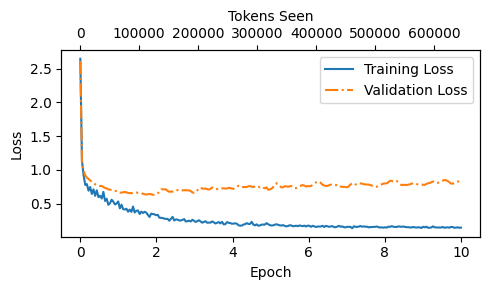

In [43]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epoch_seen,
                tokens_seen,
                train_losses,
                val_losses,
                fig_path="loss_plot.pdf"):
  """Plot training and validation loss."""

  fig, ax1 = plt.subplots(figsize=(5, 3))

  # plot training and validation loss against epochs
  ax1.plot(epoch_seen, train_losses, label="Training Loss")
  ax1.plot(epoch_seen, val_losses, linestyle="-.", label="Validation Loss")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # only show integer labels on x-axis

  # create a second x-axis for token seen
  ax2 = ax1.twiny() # create a second x-axis that shares the same y-axis
  ax2.plot(tokens_seen, train_losses, alpha=0) # invisible plot for aligning ticks
  ax2.set_xlabel("Tokens Seen")

  fig.tight_layout() # adjust layout to make room
  plt.savefig(fig_path)
  plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# 6. Extracting and saving responses

In [44]:
torch.manual_seed(211)


for entry in test_data[55:64]:

    input_text = format_input(entry)

    token_ids = generate_text(
        model=model,
        input_batch=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")
    print("-------------------------------------")
    print("-------------------------------------")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Explain the primary function of the human heart.

Correct response:
>> The primary function of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes.

Model response:
>> The primary function of the human heart is to pump blood to the body's tissues and to remove waste products. It includes the small vessels that supply the heart and the large vessels that supply the body with oxygen and nutrients.
-------------------------------------
-------------------------------------
-------------------------------------
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Reword the following sentence to the future tense.

### Input:
He is reading a novel inspired by his grandmothe

- In the next section, we will use another LLM to evaluate the responses of our model; however, we will use our own test set instead of using a publicly available benchmark dataset

- For this, we add the model response to the `test_data` dictionary and save it as a `"instruction-data-with-response.json"` file for record-keeping so that we can load and analyze it in separate Python sessions if needed

In [45]:
print("Example entry:\n", test_data[50])

Example entry:
 {'instruction': 'Edit the given text to ensure all plural nouns are spelled correctly.', 'input': 'The birds sings beautiful songs.', 'output': 'The birds sing beautiful songs.'}


In [46]:
from tqdm import tqdm

# generate responses for whole dataset
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

  input_text = format_input(entry)

  token_ids = generate_text(
      model=model,
      input_batch=text_to_token_ids(input_text, tokenizer).to(device),
      max_new_tokens=256,
      context_size=BASE_CONFIG["context_length"],
      eos_id=50256)
  generated_text = token_ids_to_text(token_ids, tokenizer)
  response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

  # add "model_response" field into `test_data`
  test_data[i]["model_response"] = response_text


# save `test_data` into .json file
with open("instruction-data-with-response.json", "w") as file:
  json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [01:04<00:00,  1.70it/s]


In [47]:
print(test_data[50])

{'instruction': 'Edit the given text to ensure all plural nouns are spelled correctly.', 'input': 'The birds sings beautiful songs.', 'output': 'The birds sing beautiful songs.', 'model_response': 'The birds sings beautiful songs.'}


- let's save the model:

In [48]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


# 7. Evaluating the finetuned LLM

- we'll use OpenAI model

In [49]:
from importlib.metadata import version

pkgs = ["openai",  # OpenAI API
        "tqdm",    # Progress bar
        ]

for p in pkgs:
    print(f"{p} version: {version(p)}")

openai version: 1.86.0
tqdm version: 4.67.1


In [50]:
#!pip install dotenv

In [51]:
from google.colab import userdata
import os
from openai import OpenAI

api_key = userdata.get("OPENAI_API_KEY")

if api_key and api_key.startswith('sk-proj-') and len(api_key)>10:
    print("API key looks good so far")
else:
    print("There might be a problem with your API key? Please visit the troubleshooting notebook!")

MODEL = "gpt-4.1-mini"
os.environ["OPENAI_API_KEY"] = api_key


client = OpenAI()

API key looks good so far


In [52]:
def run_chatgpt(prompt, client, model=MODEL):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0,
        seed=123,
    )
    return response.choices[0].message.content


prompt = "Respond with 'hello world' if you got this message."
run_chatgpt(prompt, client)

'hello world'

In [53]:
for entry in test_data[55:64]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
        f"Respond with the integer number only."
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", run_chatgpt(prompt, client))
    print("\n-------------------------")


Dataset response:
>> The primary function of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes.

Model response:
>> The primary function of the human heart is to pump blood to the body's tissues and to remove waste products. It includes the small vessels that supply the heart and the large vessels that supply the body with oxygen and nutrients.

Score:
>> 75

-------------------------

Dataset response:
>> He will be reading a novel inspired by his grandmother.

Model response:
>> He is reading a novel inspired by his grandmother.

Score:
>> 0

-------------------------

Dataset response:
>> The government passed the law.

Model response:
>> The law was passed by the government.

Score:
>> 0

-------------------------

Dataset response:
>> The confrontation was inevitable given the circumstances.

Model response:
>> The collapse of the company was inevitable due to poor management.

Score:
>> 1

In [54]:
def generate_model_scores(json_data, json_key, model=MODEL):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = run_chatgpt(prompt, client, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|██████████| 110/110 [00:38<00:00,  2.87it/s]

Number of scores: 110 of 110
Average score: 35.68



In [55]:
notebook_end_time = time.time()
runtime_in_seconds = notebook_end_time - notebook_start_time

# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"Notebook runtime: {int(minutes)} min {seconds:.2f} sec")

Notebook runtime: 7 min 6.71 sec
